In [1]:
import json
import re
import time
import random

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests

from utils.paths import URL_CONFIG_PATH, BOOKS_PATH, AUTHORS_PATH
from utils.enums import URLS, SOUP
from utils.regex import NUMBER_PATTERN, LITERAL_PATTERN

from scraping.pages import scrape_books
from scraping.session import get_session

In [3]:
with open(URL_CONFIG_PATH) as url_config_file:
    urls = json.load(url_config_file)

In [4]:
session = get_session()

In [5]:
# utils
def get_with_retry(session, url, retries=5):
    for i in range(retries):
        try:
            html = session.get(url).text
            break
        except Exception as e:
            print(f'Error: {e}')
            time.sleep(.5)
    return html

In [29]:
# Initialize lists to store book and author data
books_data_dict_list = []
authors_data_dict_list = []

# give visited_books
if BOOKS_PATH.exists():
    visited_books = set(pd.read_csv(BOOKS_PATH)['url'].unique())
else:
    visited_books = set()

# give visited_authors
if AUTHORS_PATH.exists():
    visited_authors = set(pd.read_csv(AUTHORS_PATH)['author_url'].unique())
else:
    visited_authors = set()

# Loop through pages to scrape book URLs
try:
    for step in range(1, 344):
        books_urls = scrape_books(base_url=urls[URLS.BASE], page_url=urls[URLS.PAGE].format(step=step), session=session)
        
        # Loop through each book URL to scrape book details
        for book_url in books_urls:
            # book_html = session.get(book_url).text
            book_html = get_with_retry(session, book_url)
            soup_book = BeautifulSoup(book_html, SOUP.HTML_PARSER)
            

            # Extract author names and hrefs
            authors_html = soup_book.find_all('a', class_='link-name d-inline-block')
            authors_names = [author.text for author in authors_html]
            authors_hrefs = [author['href'] for author in authors_html]

            # Scrape author
            author_href = authors_hrefs[0]
            if author_href not in visited_authors:
                author_html = get_with_retry(session, author_href)
                author_soup = BeautifulSoup(author_html, SOUP.HTML_PARSER)
                author_author_name = author_soup.find('div', class_='author-main__header-wrapper').text
                author_average_rating = float(author_soup.find('div', class_='author-box').find('span', class_='rating__avarage').text.replace(',', '.'))
                readers_div = author_soup.find_all('div', class_='author-box__readers-col')
                if readers_div is not None:
                    author_number_of_people_read = int(readers_div[0].find('span').text.replace(' ', ''))
                    number_of_people_wants_to_read = int(readers_div[1].find('span').text.replace(' ', ''))
                else:
                    author_number_of_people_read = float('nan')
                    number_of_people_wants_to_read = float('nan')
                author_date_of_birth_span = author_soup.find('span', class_='author-info__born')
                if author_date_of_birth_span is not None:
                    author_date_of_birth =  author_date_of_birth_span.text.split()[-1]
                else:
                    author_date_of_birth = str(author_date_of_birth)
                author_number_of_fans = int(author_soup.find('span', class_='author-box__number').text.replace(' ', ''))
                author_number_of_books_written = int(author_soup.find('div', class_='author-info__count').text)
                author_awards_html = author_soup.find('div', class_='author-info__count author-info__count--awards')
                if author_awards_html is not None:
                    author_number_of_awards = int(author_awards_html.text)
                else:
                    author_number_of_awards = 0
                author_data_dict = {
                    'author_name': author_author_name,
                    'author_url': author_href,
                    'author_average_rating': author_average_rating,
                    'author_number_of_people_read': author_number_of_people_read,
                    'author_number_of_people_wants_to_read': number_of_people_wants_to_read,
                    'author_date_of_birth': author_date_of_birth,
                    'author_number_of_fans': author_number_of_fans,
                    'author_number_of_books_written': author_number_of_books_written,
                    'author_number_of_awards': author_number_of_awards
                }
                authors_data_dict_list.append(author_data_dict)
                visited_authors.add(author_href)
            # Scrape author end

            # scrape publisher
            ...
            # scrape publisher end
            if book_url in visited_books:
                continue
            # Create a dictionary for authors
            authors = {}
            for index, (author_name, author_href) in enumerate(zip(authors_names, authors_hrefs)):
                number = index if index > 0 else ''
                authors[f'author{number}'] = author_name
                authors[f'author_href{number}'] = author_href
            
            # Extract book details
            pages_html = soup_book.find('span', class_='d-sm-inline-block book-pages book__pages pr-2 mr-2 pr-sm-3 mr-sm-3')
            description_html = soup_book.find('div', class_='collapse-content')
            description = description_html.text if description_html else ''
            
            # Extract user statistics
            user_stats_html = soup_book.find('div', class_='d-flex flex-wrap justify-content-around px-3')
            if user_stats_html is None:
                number_of_discussions = 0
                number_of_user_opinions = 0
                number_of_user_ratings = 0
            else:
                user_stats = user_stats_html.text
                user_stats = list(map(int, re.findall(NUMBER_PATTERN, user_stats)))
            
                if len(user_stats) == 2:
                    number_of_user_opinions, number_of_user_ratings = user_stats
                    number_of_discussions = 0
                elif len(user_stats) == 3:
                    number_of_user_opinions, number_of_user_ratings, number_of_discussions = user_stats
            
            # Extract additional book details
            details_dict = dict(zip(
                [element.text.strip().rstrip(':') for element in soup_book.find_all('dt')],
                [element.text.strip() for element in soup_book.find_all('dd')]
            ))
            
            # Extract on-the-shelf statistics
            on_the_shelf_dict_raw = {
                re.search(LITERAL_PATTERN, element.text).group().strip(): "".join(re.findall(NUMBER_PATTERN, element.text))
                for element in soup_book.find_all('li', class_='list-group-item p-0')
            }
            on_the_shelf_dict = {
                'number_of_people_read': on_the_shelf_dict_raw.get('Przeczytane', np.nan),
                'number_of_people_has': on_the_shelf_dict_raw.get('Posiadam', np.nan),
                'number_of_people_favorite': on_the_shelf_dict_raw.get('Ulubione', np.nan),
                'number_of_people_wants_to_read': on_the_shelf_dict_raw.get('Chcę przeczytać', np.nan),
                'number_of_people_wants_as_gift': on_the_shelf_dict_raw.get('Chcę w prezencie', np.nan),
                'number_of_people_currently_read': on_the_shelf_dict_raw.get('Teraz czytam', np.nan)
            }
            
            # Extract tags
            tags = '&'.join([element.text.strip() for element in soup_book.find_all('a', class_='tag')])
            
            # Extract ratings
            ratings_dict = {
                f'rating_{element["data-rating"]}': int("".join(re.findall(NUMBER_PATTERN, element.text.strip())))
                for element in soup_book.find_all('a', class_='chart-valuebtn btn-link--without-bold plusCountModal')
            }
            
            # Combine all extracted data into a single dictionary
            books_data_dict = {
                **authors,
                'description': description,
                'number_of_user_opinions': number_of_user_opinions,
                'number_of_user_ratings': number_of_user_ratings,
                'number_of_discussions': number_of_discussions,
                **details_dict,
                **on_the_shelf_dict,
                'tags': tags,
                **ratings_dict,
                'url': book_url
            }
            
            # Append the book data dictionary to the list
            books_data_dict_list.append(books_data_dict)
            
            # Sleep for a random time between requests to avoid being blocked
            random_sleep_time = random.uniform(0.5, 1.5)
            time.sleep(random_sleep_time)
        # print current step of the loop and the only current step of the loop
        print(f'Current step: {step}', end='\r')
except Exception as e:
    print(f'Error: {e}')
    # print traceback
    import traceback
    print('something went wrong')
    traceback.print_exc()
    # save data frames as tmp data frames to be merged later
    books_df_tmp = pd.DataFrame(books_data_dict_list)
    authors_df_tmp = pd.DataFrame(authors_data_dict_list)
    books_df_tmp.to_csv('books_tmp.csv', index=False)
    authors_df_tmp.to_csv('authors_tmp.csv', index=False)
    print('tmp data frames saved')


Error: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))


In [27]:
author_soup.find_all('div', class_='author-box__readers-col')[0].find('span').text.replace(' ', '')

'26656'

In [30]:
books_df = pd.DataFrame(books_data_dict_list)
authors_df = pd.DataFrame(authors_data_dict_list)

In [34]:
authors_df.to_csv('authors_tmp.csv', index=False)

In [33]:
books_df.to_csv('books_tmp.csv', index=False)

In [102]:
author_href = books_df['author_href'][0]

In [35]:
books_df

,author,author_href,description,number_of_user_opinions,number_of_user_ratings,number_of_discussions,Kategoria,Format,Wydawnictwo,Data wydania,...,author14,author_href14,author15,author_href15,author16,author_href16,author17,author_href17,author18,author_href18
0,praca zbiorowa,https://lubimyczytac.pl/autor/8337/praca-zbiorowa,"Biblia tzw. Brzeska (albo Pińczowska, albo Ra...",0,0,0,religia,papier,"Arka, Cieszyńska Drukarnia Wydawnicza, Collegi...",2003-01-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Agata Romaniuk,https://lubimyczytac.pl/autor/71959/agata-roma...,O pierwszych miłościach powiedziano prawie ws...,396,2616,0,reportaż,papier,Wydawnictwo Poznańskie,2022-10-12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Ewa Nowak,https://lubimyczytac.pl/autor/5021/ewa-nowak,"Klasa maturalna, przystojniak Kuba Gwidosz je...",200,2502,0,literatura młodzieżowa,papier,Egmont Polska,2012-01-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Adam Mickiewicz,https://lubimyczytac.pl/autor/6520/adam-mickie...,W Dziadach. Część II Adam Mickiewicz sięga do...,155,2511,0,"utwór dramatyczny (dramat, komedia, tragedia)",papier,IBIS,2017-06-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Meg Cabot,https://lubimyczytac.pl/autor/6222/meg-cabot,"Do tańca proszą wampir, który zawrócił w głow...",234,2474,0,"fantasy, science fiction",papier,Amber,2010-01-13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8138,Sally Page,https://lubimyczytac.pl/autor/230535/sally-page,"...zauważyła, że ludzieopowiadają jej swoje h...",154,573,1,"literatura obyczajowa, romans",papier,Insignis,2022-09-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8139,Natalia Sońska,https://lubimyczytac.pl/autor/115156/natalia-s...,"Gdybyś mogła mieć jedno życzenie, które na pe...",138,573,0,"literatura obyczajowa, romans",papier,Czwarta Strona,2020-10-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8140,Harry Harrison,https://lubimyczytac.pl/autor/20127/harry-harr...,"Na skrajnie przeludnionej, zdegradowanej Ziem...",90,546,0,"fantasy, science fiction",papier,Rebis,2019-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8141,Anna Ciarkowska,https://lubimyczytac.pl/autor/153763/anna-ciar...,"Przepraszam, czy mogę się u ciebie schować?Cz...",94,558,0,poezja,papier,Otwarte,2018-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
if BOOKS_PATH.exists():
    existing_books_df = pd.read_csv(BOOKS_PATH)
else:
    existing_books_df = pd.DataFrame()
if AUTHORS_PATH.exists():
    existing_authors_df = pd.read_csv(AUTHORS_PATH)
else:
    existing_authors_df = pd.DataFrame()

/tmp/ipykernel_133533/734529333.py:2: DtypeWarning: Columns (66,67,68,69,70,71,72,73,74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  existing_books_df = pd.read_csv(BOOKS_PATH)


In [55]:
existing_books_df.columns

Index(['author', 'author_href', 'description', 'number_of_user_opinions',
       'number_of_user_ratings', 'number_of_discussions', 'Kategoria',
       'Format', 'Cykl', 'Tytuł oryginału', 'Wydawnictwo', 'Data wydania',
       'Data 1. wyd. pol.', 'Data 1. wydania', 'Liczba stron', 'Czas czytania',
       'Język', 'ISBN', 'Tłumacz', 'Ekranizacje', 'number_of_people_read',
       'number_of_people_has', 'number_of_people_favorite',
       'number_of_people_wants_to_read', 'number_of_people_wants_as_gift',
       'number_of_people_currently_read', 'tags', 'rating_10', 'rating_9',
       'rating_8', 'rating_7', 'rating_6', 'rating_5', 'rating_4', 'rating_3',
       'rating_2', 'rating_1', 'url', 'Inne', 'author1', 'author_href1',
       'Seria', 'author2', 'author_href2', 'author3', 'author_href3',
       'author4', 'author_href4', 'author5', 'author_href5', 'author6',
       'author_href6', 'author7', 'author_href7', 'author8', 'author_href8',
       'author9', 'author_href9', 'author10'

In [70]:
existing_books_df['average_rating'] = np.multiply(np.arange(10, 0, -1), existing_books_df.loc[:, 'rating_10':'rating_1']).sum(axis=1)/existing_books_df.loc[:, 'rating_10':'rating_1'].sum(axis=1)

In [75]:
existing_books_df.groupby('Kategoria').average_rating.mean().sort_values(ascending=True)

Kategoria
rękodzieło                                             5.559966
opowieści dla młodszych dzieci                         6.049046
film, kino, telewizja                                  6.250125
ezoteryka, senniki, horoskopy                          6.331966
rozrywka                                               6.451970
bajki                                                  6.680276
opowiadania, powieści dla dzieci                       6.699271
informatyka, matematyka                                6.707806
horror                                                 6.814918
utwór dramatyczny (dramat, komedia, tragedia)          6.830849
poradniki                                              6.862672
klasyka                                                6.872499
wierszyki, piosenki                                    6.967492
literatura piękna                                      7.057596
kryminał, sensacja, thriller                           7.074226
pozostałe                     

In [76]:
total_ratings = existing_books_df.loc[:, 'rating_10':'rating_1'].sum(axis=1)

In [77]:
one_rating_normalized = existing_books_df['rating_1']/total_ratings

In [85]:
one_rating_normalized.sort_values(ascending=False)[:5]

3583    0.282759
5983    0.196057
6200    0.195011
5984    0.182425
4517    0.179054
dtype: float64

In [106]:
existing_books_df.loc[one_rating_normalized.sort_values(ascending=False)[:20].index, ['author', 'Tytuł oryginału', 'average_rating', 'description', 'Data 1. wydania', 'ISBN']]

,author,Tytuł oryginału,average_rating,description,Data 1. wydania,ISBN
3583,Harvard Lampoon,Nightlight: A parody,3.466207,"Zabawny, zaskakujący pastisz słynnego ""Zmierz...",NaN,978-83-247-1886-3
5983,Barbara Jasnyk,NaN,3.759036,Basia Jasnyk z popularnego serialu TERAZ ALBO...,NaN,978-83-7414-537-4
6200,Jina Bacarr,Blonde geisha,4.223356,Wczesna wiosna 1892 roku przyniosła w Japonii...,NaN,9788323853206
5984,Michael Gerber,Barry Trotter and the Shameless Parody,4.027809,Barry Trotter ma 22 lata i wciąż studiuje w S...,NaN,8374800097
4517,Keri Smith,Wreck this journal. To create is to destroy,5.559966,"Światowy bestseller, którego nakład przekrocz...",2007-06-01,9788364853005
4376,Izabela Kuna,NaN,4.175000,"Klara Izy Kuny – głośny, bestsellerowy debiut...",NaN,9788383600505
4721,Anne Rice,The Claiming of Sleeping Beauty,4.168430,Po stu latach Śpiąca Królewna zostaje przebud...,2004-01-01,9788377190012
5992,Adolf Hitler,NaN,4.194719,Mein Kampf Adolfa Hitlera to jedna z najbardz...,2021-01-01,9788311181038
4890,Katarzyna Michalak,NaN,5.221821,"Ferrin to świat, w którym rządzą okrucieństwo...",NaN,9788308055731
4488,Katarzyna Michalak,NaN,4.877869,Ulice Miasta po zmroku pustoszeją. Giną piękn...,NaN,9788363622947


In [99]:
ten_rating_normalized = existing_books_df['rating_10']/total_ratings

In [107]:
existing_books_df.loc[ten_rating_normalized.sort_values(ascending=False)[:10].index, ['author', 'Tytuł oryginału', 'average_rating', 'description', 'Data 1. wydania', 'ISBN']]

,author,Tytuł oryginału,average_rating,description,Data 1. wydania,ISBN
8234,Mateusz Samołyk,NaN,9.580699,"Od jakiegoś czasu myślisz o inwestowaniu, ale...",NaN,9788396734808
8248,Andrzej Gryżewski,NaN,9.209469,Kontynuacja bestsellerowej „Sztuki obsługi pe...,NaN,9788326842528
5327,Damian Poprawa,NaN,8.975952,"Co zrobić, jeśli ktoś kogo kochałaś zupełnie ...",NaN,9788395929823
5495,Cezary Głuch,NaN,8.692458,Co jest ważniejsze – rynek akcji czy obligacj...,NaN,9788395645211
8413,Cezary Głuch,NaN,8.795888,Dlaczego bankierzy i politycy demonizują złot...,NaN,9788395645228
9325,Cezary Głuch,NaN,8.721683,Dlaczego inwestowanie wyłącznie w akcje jest ...,NaN,9788395645235
398,Brandon Sanderson,Words of Radiance,9.081298,Świetliści Rycerze muszą znów powstać. W końc...,2014-03-04,9788366409507
7790,Katarzyna Barlińska P.S. Herytiera,NaN,8.539095,"Jeśli przegramy, szukaj mnie w zgliszczach mi...",NaN,9788328907034
1996,Marcin Iwuć,NaN,8.954857,"Chcesz inwestować, ale nie wiesz, od czego za...",NaN,9788395846809
6216,św. Faustyna Kowalska,NaN,8.560890,„Dzienniczek” należy do pereł literatury mist...,NaN,9788366093430


In [123]:
existing_books_df.loc[existing_books_df.average_rating.sort_values(ascending=False)[:10].index, ['author', 'Tytuł oryginału', 'average_rating', 'description', 'Data 1. wydania', 'url']]

,author,Tytuł oryginału,average_rating,description,Data 1. wydania,url
8234,Mateusz Samołyk,NaN,9.580699,"Od jakiegoś czasu myślisz o inwestowaniu, ale...",NaN,https://lubimyczytac.pl/ksiazka/5088590/inwest...
8248,Andrzej Gryżewski,NaN,9.209469,Kontynuacja bestsellerowej „Sztuki obsługi pe...,NaN,https://lubimyczytac.pl/ksiazka/5097467/sztuka...
398,Brandon Sanderson,Words of Radiance,9.081298,Świetliści Rycerze muszą znów powstać. W końc...,2014-03-04,https://lubimyczytac.pl/ksiazka/4905352/slowa-...
5327,Damian Poprawa,NaN,8.975952,"Co zrobić, jeśli ktoś kogo kochałaś zupełnie ...",NaN,https://lubimyczytac.pl/ksiazka/4976000/wolna-...
1996,Marcin Iwuć,NaN,8.954857,"Chcesz inwestować, ale nie wiesz, od czego za...",NaN,https://lubimyczytac.pl/ksiazka/4940535/finans...
5133,Dave Gibbons,Absolute Watchmen,8.951220,"Monumentalne dzieło, które zburzyło stereotyp...",1986-01-01,https://lubimyczytac.pl/ksiazka/4990511/straznicy
9875,Mario Puzo,The Godfather / The Sicilian / The Last Don,8.942708,Wyjątkowe wydanie ze wstępem Francisa Forda C...,NaN,https://lubimyczytac.pl/ksiazka/5042856/ojciec...
3476,Larry McMurtry,Lonesome Dove,8.894771,Oddana po raz pierwszy do rąk czytelników w 1...,NaN,https://lubimyczytac.pl/ksiazka/4799556/na-pol...
272,Brandon Sanderson,The Way of Kings,8.831343,Tęsknię za dniami przed Ostatnim Spustoszenie...,2010-08-31,https://lubimyczytac.pl/ksiazka/4896952/droga-...
5435,Lisa Aisato,Snøsøsteren,8.798246,"Wigilijna opowieść, która zostanie z wami na ...",NaN,https://lubimyczytac.pl/ksiazka/4896409/sniezn...


<Axes: xlabel='tags'>

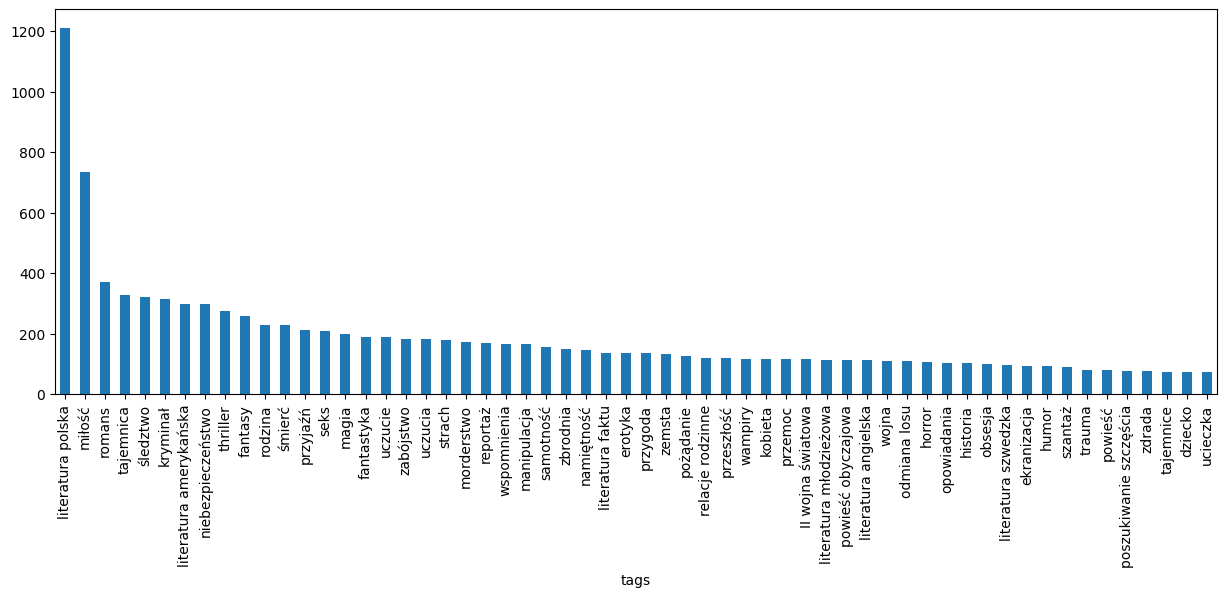

In [134]:
existing_books_df['tags'].str.split('&').explode().value_counts()[existing_books_df['tags'].str.split('&').explode().value_counts() > 70].plot(kind='bar', figsize=(15, 5))

In [154]:
existing_books_df[existing_books_df['Tytuł oryginału'].isna()]['url'].str.split('/').str[-1].str.split('-').str.join(' ').str.title()

8                            Hobbit Czyli Tam I Z Powrotem
9                                                     1984
11                                       Ostatnie Zyczenie
15                                              Krew Elfow
19                                     Miecz Przeznaczenia
                               ...                        
10006    Ksiazka Ktora Napisalem Zeby Miec Na Dziwki I ...
10013                                            Deweloper
10014                                            Wystarczy
10016                                 Otworz Sie Na Milosc
10018                               Chlopcy Ktorych Kocham
Name: url, Length: 3510, dtype: object

In [168]:
existing_authors_df[existing_books_df['Liczba stron'] == 667.0]

/tmp/ipykernel_133533/645390628.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  existing_authors_df[existing_books_df['Liczba stron'] == 667.0]


,author_name,author_url,author_average_rating,author_number_of_people_read,author_number_of_people_wants_to_read,author_date_of_birth,author_number_of_fans,author_number_of_books_written,author_number_of_awards


<Axes: title={'center': 'Rozkład liczby stron w książkach'}, ylabel='Frequency'>

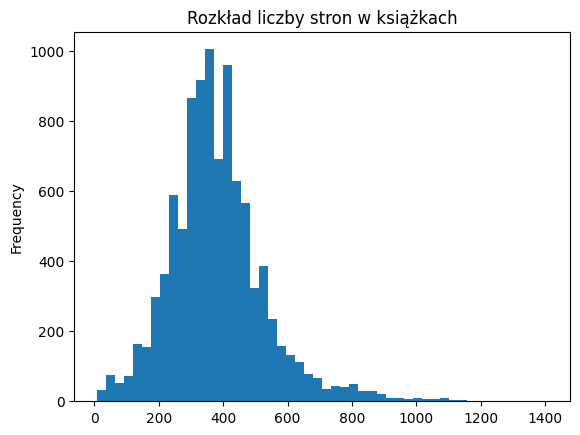

In [171]:
existing_books_df['Liczba stron'].plot(kind='hist', bins=50, title='Rozkład liczby stron w książkach')

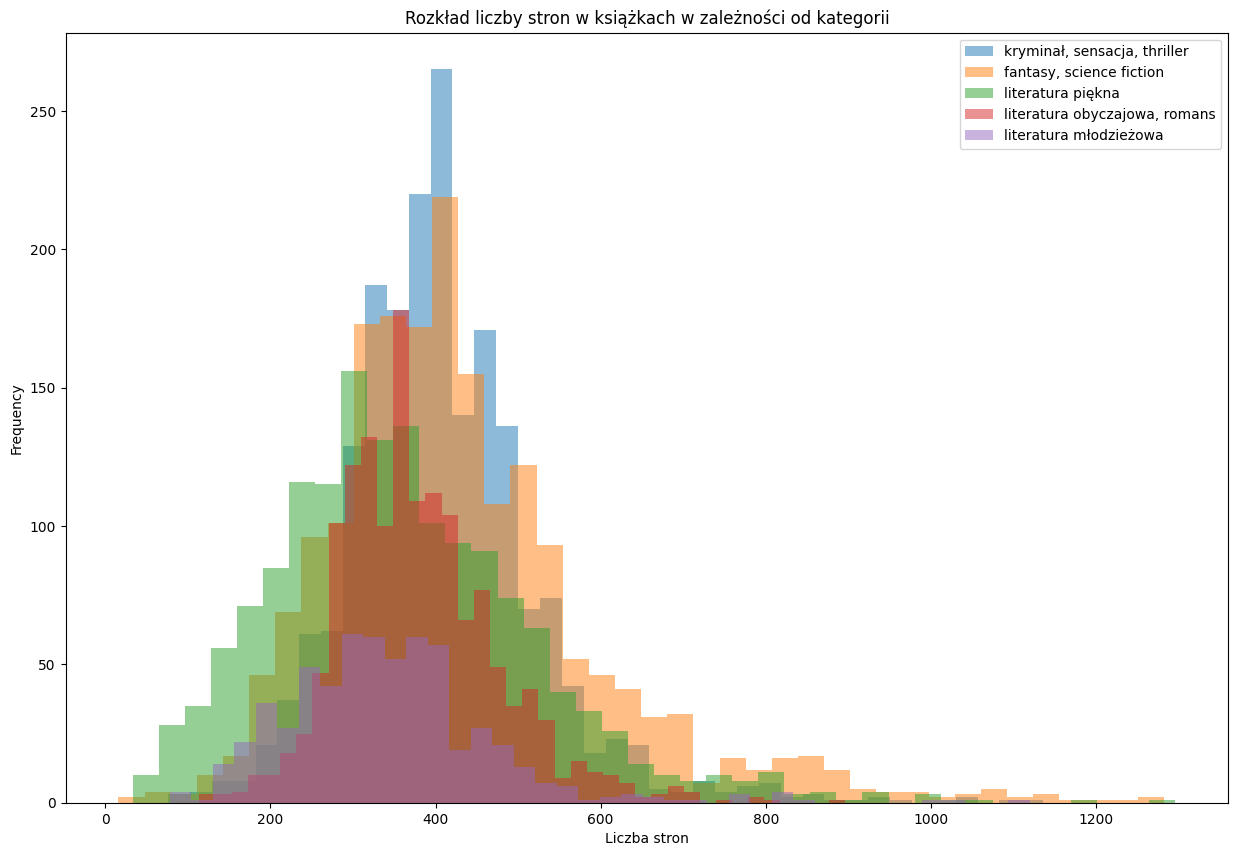

In [175]:
import matplotlib.pyplot as plt

# Filter categories with more than 100 books
filtered_categories = existing_books_df['Kategoria'].value_counts()
filtered_categories = filtered_categories[filtered_categories > 500].index

# Plot histograms for each filtered category
plt.figure(figsize=(15, 10))
for category in filtered_categories:
    subset = existing_books_df[existing_books_df['Kategoria'] == category]
    subset['Liczba stron'].plot(kind='hist', bins=40, alpha=0.5, label=category)

plt.title('Rozkład liczby stron w książkach w zależności od kategorii')
plt.xlabel('Liczba stron')
plt.ylabel('Frequency')
plt.legend()
plt.show()

/tmp/ipykernel_133533/3211361258.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_categories = filtered_categories[filtered_categories > 100][[0]].index


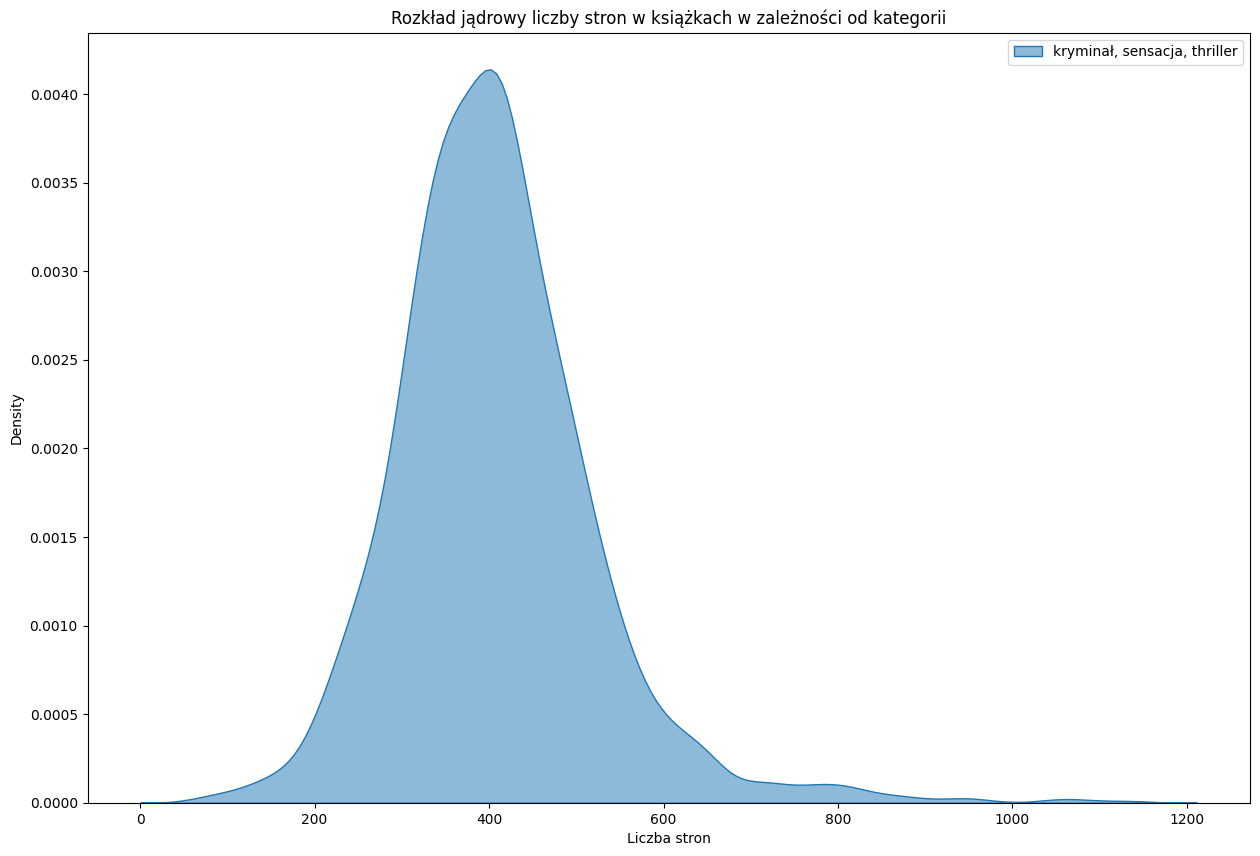

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter categories with more than 100 books
filtered_categories = existing_books_df['Kategoria'].value_counts()
filtered_categories = filtered_categories[filtered_categories > 100][[0]].index

# Plot KDE for each filtered category
plt.figure(figsize=(15, 10))
for category in filtered_categories:
    subset = existing_books_df[existing_books_df['Kategoria'] == category]
    sns.kdeplot(subset['Liczba stron'], label=category, fill=True, alpha=0.5)

plt.title('Rozkład jądrowy liczby stron w książkach w zależności od kategorii')
plt.xlabel('Liczba stron')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
existing_books_df.groupby('Kategoria')

Series([], Name: count, dtype: int64)

In [ ]:
plt.figure(figsize=(15, 10))
# for category in filtered_categories:
subset = existing_books_df['Kategoria']
sns.kdeplot(subset['Liczba stron'], label=category, fill=True, alpha=0.5)

plt.title('Rozkład jądrowy liczby stron w książkach w zależności od kategorii')
plt.xlabel('Liczba stron')
plt.ylabel('Density')
plt.legend()
plt.show()

In [200]:
existing_books_df.head().columns

Index(['author', 'author_href', 'description', 'number_of_user_opinions',
       'number_of_user_ratings', 'number_of_discussions', 'Kategoria',
       'Format', 'Cykl', 'Tytuł oryginału', 'Wydawnictwo', 'Data wydania',
       'Data 1. wyd. pol.', 'Data 1. wydania', 'Liczba stron', 'Czas czytania',
       'Język', 'ISBN', 'Tłumacz', 'Ekranizacje', 'number_of_people_read',
       'number_of_people_has', 'number_of_people_favorite',
       'number_of_people_wants_to_read', 'number_of_people_wants_as_gift',
       'number_of_people_currently_read', 'tags', 'rating_10', 'rating_9',
       'rating_8', 'rating_7', 'rating_6', 'rating_5', 'rating_4', 'rating_3',
       'rating_2', 'rating_1', 'url', 'Inne', 'author1', 'author_href1',
       'Seria', 'author2', 'author_href2', 'author3', 'author_href3',
       'author4', 'author_href4', 'author5', 'author_href5', 'author6',
       'author_href6', 'author7', 'author_href7', 'author8', 'author_href8',
       'author9', 'author_href9', 'author10'